<a href="https://colab.research.google.com/github/EvelineC12/TopicosContemporaneos/blob/main/Exercicio10_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Décimo Trabalho**

**Nome:Eveline Cavalcanti Feliciano Pontual**

In [1]:
# Baixa e extrai o dataset
!mkdir data/
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  2146k      0  0:00:05  0:00:05 --:--:-- 2951k
Archive:  data/animais.zip
   creating: data/animais/
   creating: data/animais/val/
   creating: data/animais/val/tatu/
  inflating: data/animais/val/tatu/10242.jpg  
  inflating: data/animais/val/tatu/10209.jpg  
  inflating: data/animais/val/tatu/10251.jpg  
  inflating: data/animais/val/tatu/10202.jpg  
  inflating: data/animais/val/tatu/10243.jpg  
  inflating: data/animais/val/tatu/10215.jpg  
  inflating: data/animais/val/tatu/10254.jpg  
  inflating: data/animais/val/tatu/10241.jpg  
  inflating: data/animais/val/tatu/10238.jpg  
  inflating: data/animais/val/tatu/10228.jpg  
  inflating: data/animais/val/tatu/10203.jpg  
  inflating: data/animais/val/tatu/10236.jpg  

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [5]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [6]:
model = models.resnet18()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 13/13 [01:54<00:00,  8.84s/it]


Epoch 1, Train Loss: 0.736, Train Accuracy: 49.75%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.686, Val Accuracy: 55.74%


100%|██████████| 13/13 [01:52<00:00,  8.69s/it]


Epoch 2, Train Loss: 0.695, Train Accuracy: 56.50%
Epoch 2, Val Loss: 0.680, Val Accuracy: 54.10%


100%|██████████| 13/13 [01:53<00:00,  8.72s/it]


Epoch 3, Train Loss: 0.686, Train Accuracy: 55.75%
Epoch 3, Val Loss: 0.667, Val Accuracy: 61.48%


100%|██████████| 13/13 [01:57<00:00,  9.04s/it]


Epoch 4, Train Loss: 0.692, Train Accuracy: 52.75%
Epoch 4, Val Loss: 0.674, Val Accuracy: 54.92%


100%|██████████| 13/13 [01:54<00:00,  8.79s/it]


Epoch 5, Train Loss: 0.674, Train Accuracy: 59.75%
Epoch 5, Val Loss: 0.666, Val Accuracy: 62.30%
Treinamento concluído


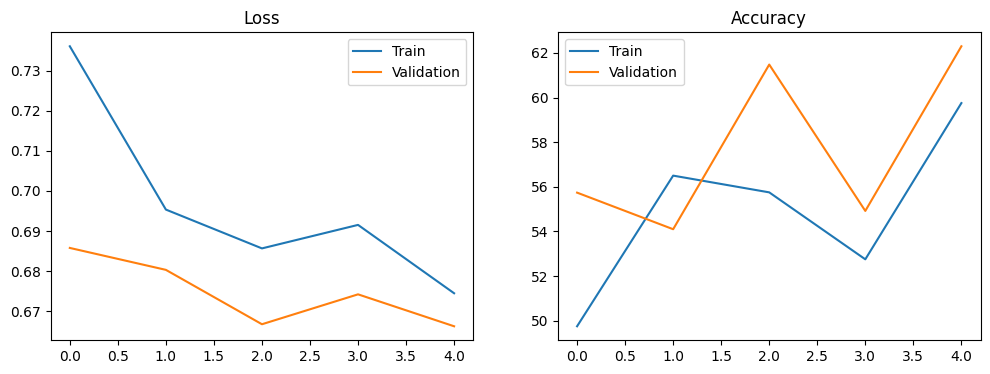

Acurácia da rede na base de teste: 62.30%


In [8]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [9]:
# Utilizando pesos pré-treinados
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


In [10]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [11]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

100%|██████████| 13/13 [00:44<00:00,  3.44s/it]


Epoch 1, Train Loss: 0.730, Train Accuracy: 51.75%
Epoch 1, Val Loss: 0.500, Val Accuracy: 77.87%


100%|██████████| 13/13 [00:44<00:00,  3.43s/it]


Epoch 2, Train Loss: 0.455, Train Accuracy: 80.00%
Epoch 2, Val Loss: 0.305, Val Accuracy: 87.70%


100%|██████████| 13/13 [00:43<00:00,  3.36s/it]


Epoch 3, Train Loss: 0.364, Train Accuracy: 83.50%
Epoch 3, Val Loss: 0.188, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:43<00:00,  3.35s/it]


Epoch 4, Train Loss: 0.322, Train Accuracy: 86.50%
Epoch 4, Val Loss: 0.167, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:43<00:00,  3.34s/it]


Epoch 5, Train Loss: 0.313, Train Accuracy: 87.00%
Epoch 5, Val Loss: 0.201, Val Accuracy: 91.80%
Treinamento concluído


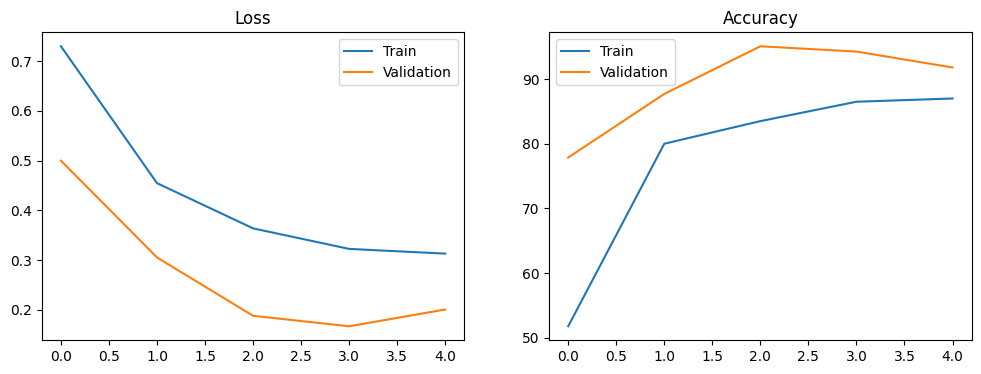

Acurácia da rede na base de teste: 91.80%


In [12]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [13]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

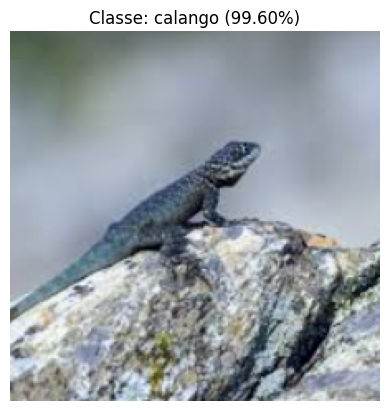

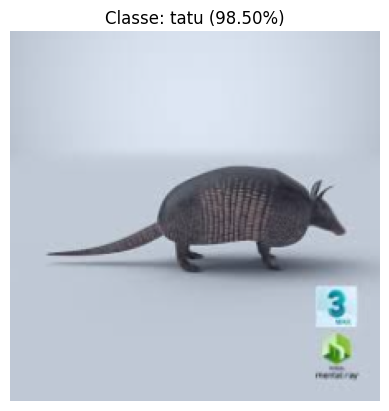

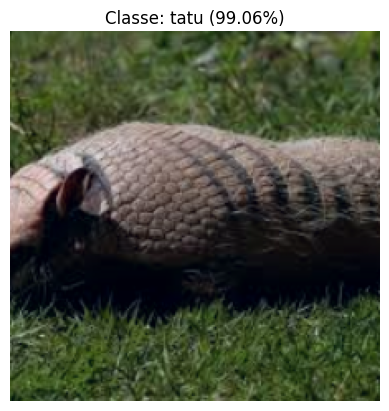

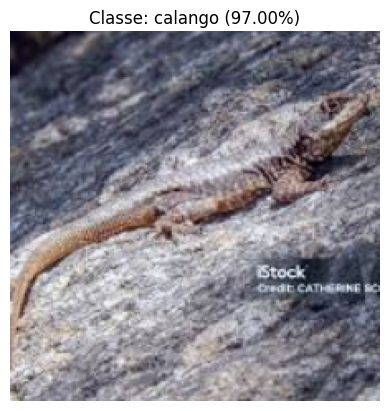

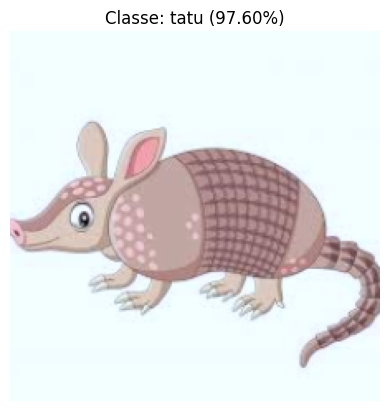

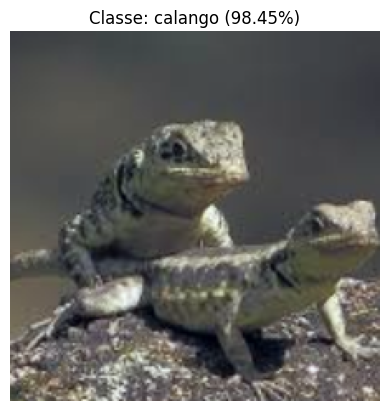

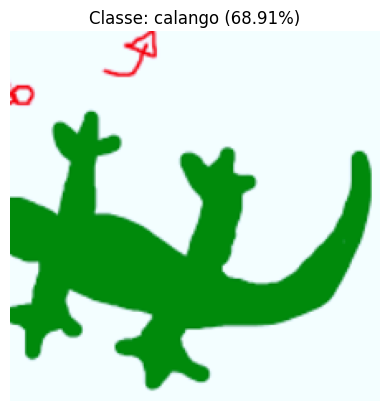

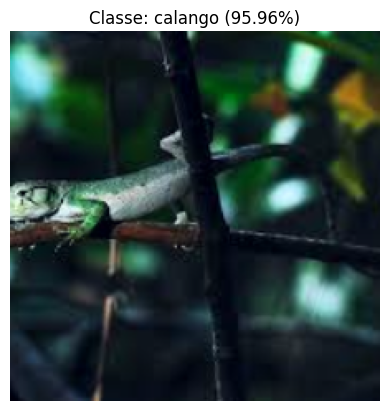

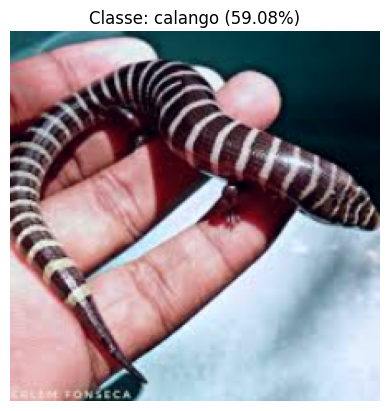

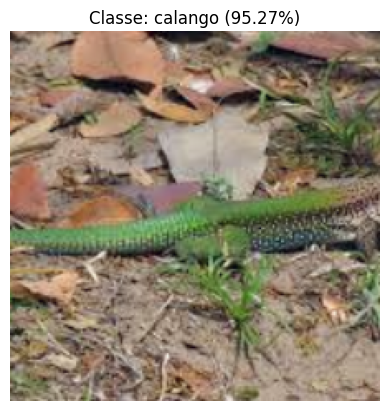

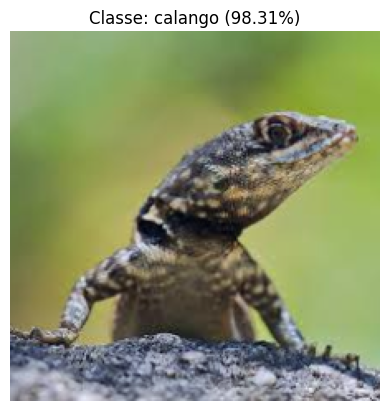

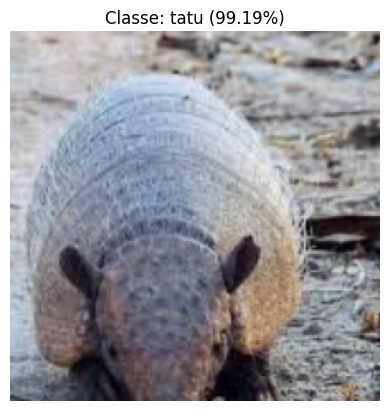

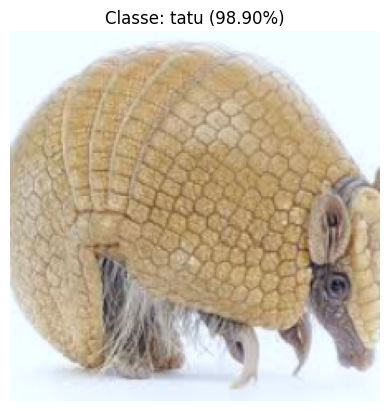

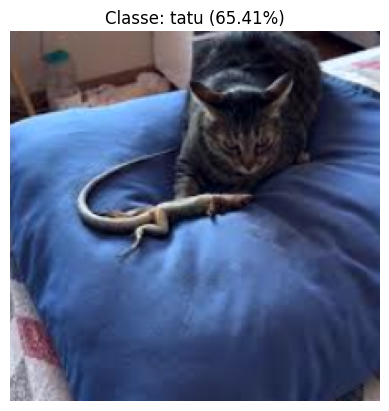

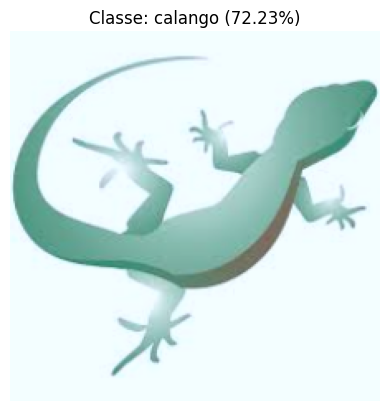

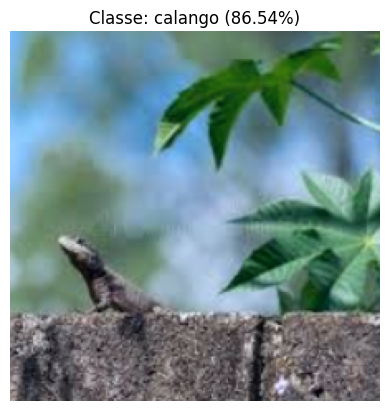

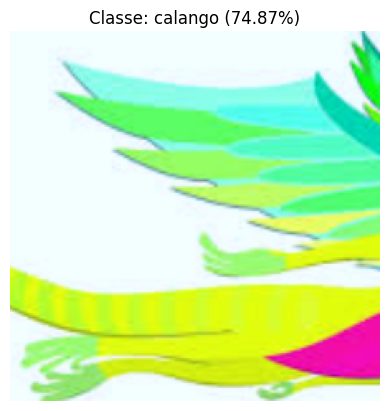

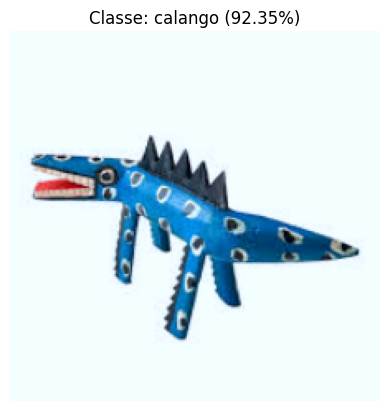

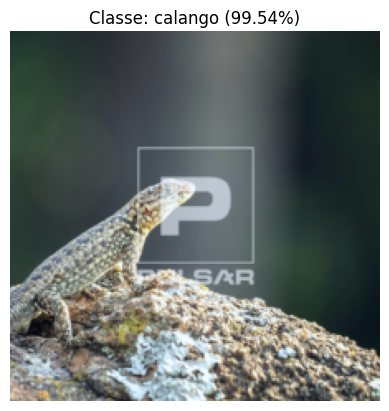

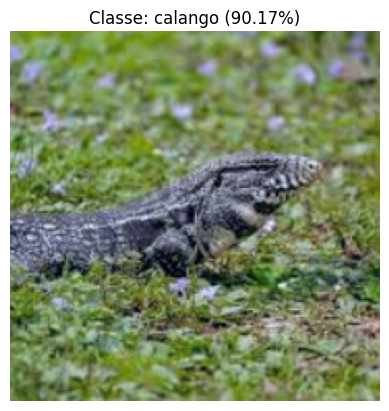

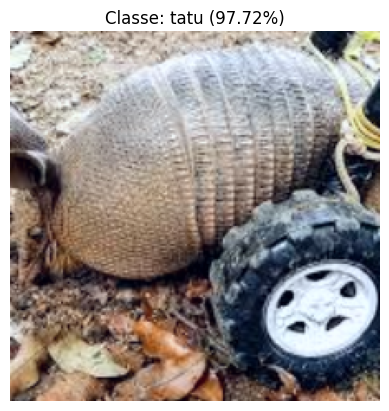

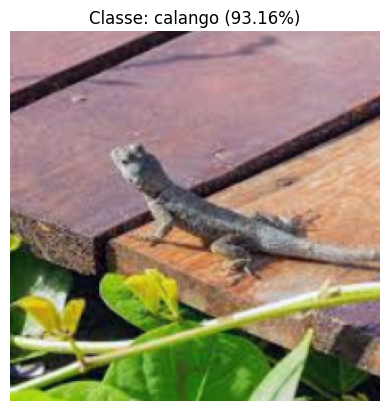

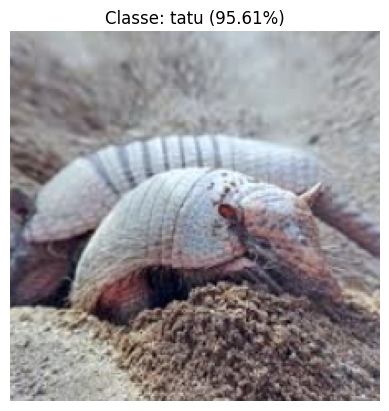

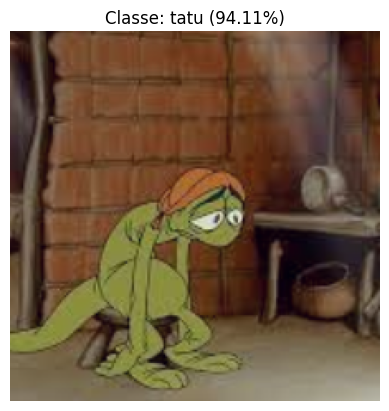

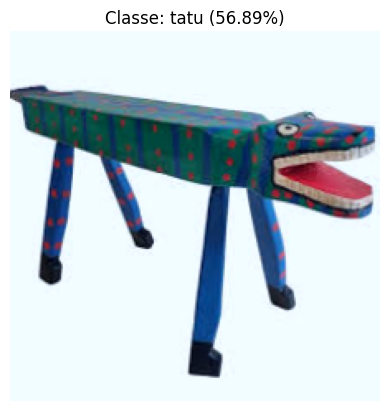

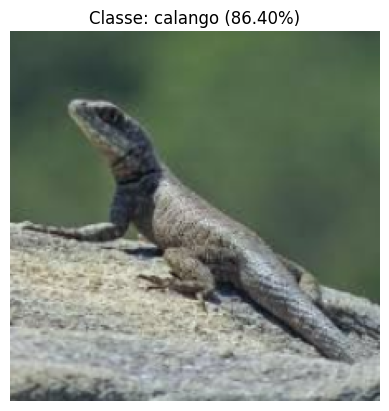

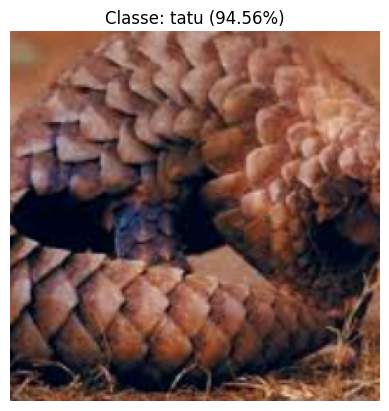

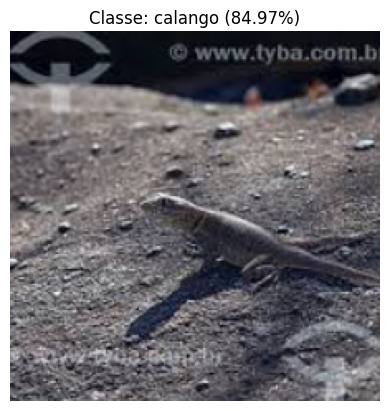

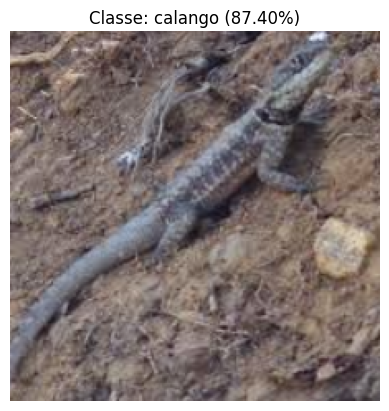

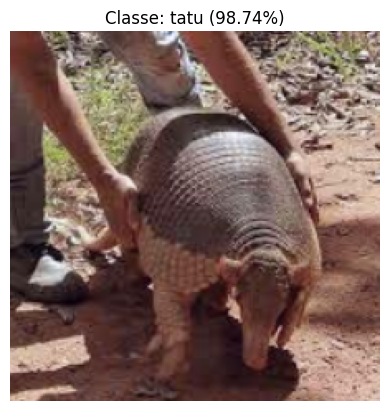

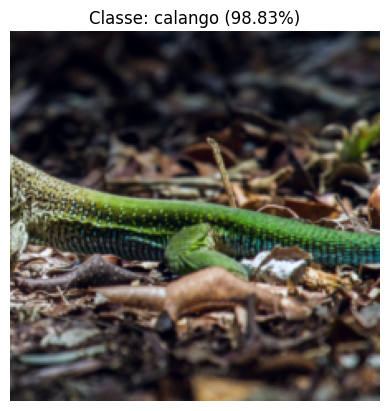

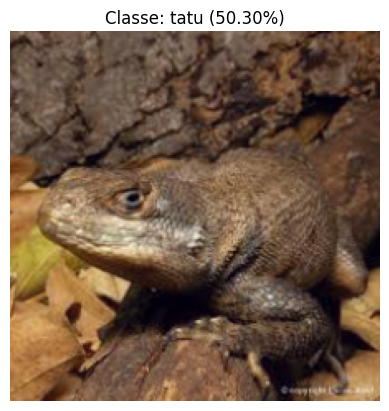

In [14]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

100%|██████████| 13/13 [00:48<00:00,  3.76s/it]


Epoch 1, Train Loss: 0.163, Train Accuracy: 95.25%
Epoch 1, Val Loss: 0.139, Val Accuracy: 97.54%


100%|██████████| 13/13 [00:43<00:00,  3.37s/it]


Epoch 2, Train Loss: 0.144, Train Accuracy: 96.50%
Epoch 2, Val Loss: 0.150, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:43<00:00,  3.35s/it]


Epoch 3, Train Loss: 0.142, Train Accuracy: 96.50%
Epoch 3, Val Loss: 0.138, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:43<00:00,  3.35s/it]


Epoch 4, Train Loss: 0.141, Train Accuracy: 96.00%
Epoch 4, Val Loss: 0.134, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:44<00:00,  3.41s/it]


Epoch 5, Train Loss: 0.130, Train Accuracy: 96.50%
Epoch 5, Val Loss: 0.132, Val Accuracy: 95.90%
Treinamento concluído


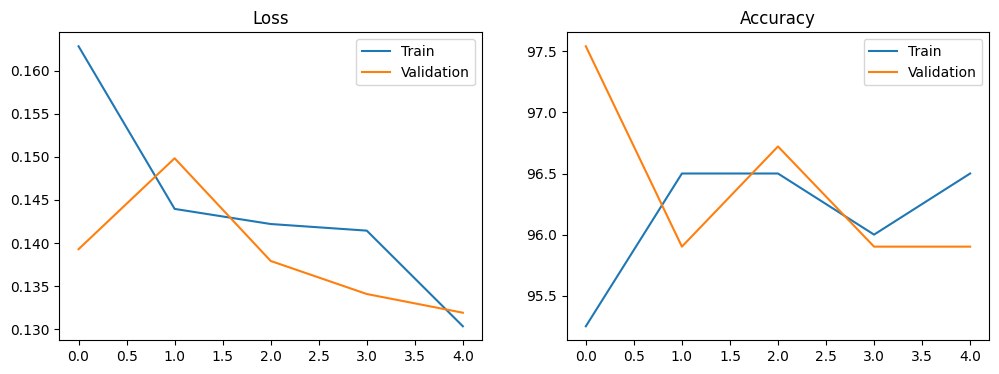

Acurácia da rede na base de teste: 95.90%


In [15]:
# Carregando os datasets sem data augmentation
transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
val_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)
val_loader_no_aug = DataLoader(val_set_no_aug, batch_size=32, shuffle=True)

# Treinando a CNN sem data augmentation
history_no_aug = train_model(model, train_loader_no_aug, val_loader_no_aug, criterion, optimizer, device, num_epochs=5)

# Plotando as curvas de treinamento
plot_history(history_no_aug)

# Testando a rede
test_model(model, val_loader_no_aug)


Primeiro é importante analisar a importância do Data Augmentation para os modelos.O data augmentation pode melhorar a generalização do modelo, já que ele treina com variações das imagens. Isso pode ajudar o modelo a aprender de forma mais robusta, evitando overfitting, especialmente em conjuntos de dados pequenos. As curvas de loss e accuracy geralmente tendem a mostrar um melhor desempenho em dados de validação, pois o modelo é mais adaptado a variações no estilo das imagens. A sua desvantagem é no tempo de treinamento que é mais longo, pois o modelo está vendo mais variações de imagens. Ademais, as curvas de perda - train loss podem ser mais irregulares, uma vez que as imagens são constantemente modificadas durante o treinamento. E a validação geralmente tem uma acurácia mais alta após algumas épocas de treinamento, uma vez que o modelo aprende a lidar com mais variações nos dados.

O treinamento sem Data Augmentation normalmente é mais rápido, já que as imagens não são transformadas a cada época. Isso resulta em uma convergência mais estável. As curvas de train loss geralmente são mais suaves e mais consistentes, já que o modelo está treinando com as mesmas imagens a cada época.
As desvantagens é que o modelo pode overfitar mais facilmente, especialmente em conjuntos de dados pequenos, já que ele não é exposto a variações de imagem. Isso pode resultar em um desempenho inferior na validação e em dados de teste.
A acurácia de validação pode ser mais baixa, pois o modelo não tem a capacidade
de generalização e o modelo tende a atingir o ápice mais rapidamente, uma vez que ele pode estar sofrendo de overfitting.

No presente caso, o modelo com Data Augmentation teve maior perda e acurácia na fase de validação. A acurácia da rede na base de teste foi 95.90%. Já o modelo sem Data Augmentation teve maior acurácia na fase de validação mas depois que chegou no ápice começou a declinar, de modo que no final a acurácia da fase de treino ficou mais elevada. E a Acurácia da rede na base de teste foi 95.08%, um pouco menor do que o modelo com Data Augmentation.


### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

In [16]:
# Descongelando camadas específicas - model.layer4
def unfreeze_layers(model, layers_to_unfreeze=["layer4"]):
    for name, param in model.named_parameters():
        # Se a camada for uma das camadas especificadas para descongelar
        if any(layer in name for layer in layers_to_unfreeze):
            param.requires_grad = True  # Descongelando a camada
        else:
            param.requires_grad = False  # Congelando as outras camadas

# Descongelando 'layer4' no modelo ResNet18
unfreeze_layers(model, layers_to_unfreeze=["layer4"])

# Verificando as camadas descongeladas
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Camada descongelada: {name}")

# Recarregar os carregadores de dados
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

# Treinando novamente a rede com camadas descongeladas
history_unfreezed = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

# Testando o modelo treinado
test_model(model, val_loader)
print(test_model)


Camada descongelada: layer4.0.conv1.weight
Camada descongelada: layer4.0.bn1.weight
Camada descongelada: layer4.0.bn1.bias
Camada descongelada: layer4.0.conv2.weight
Camada descongelada: layer4.0.bn2.weight
Camada descongelada: layer4.0.bn2.bias
Camada descongelada: layer4.0.downsample.0.weight
Camada descongelada: layer4.0.downsample.1.weight
Camada descongelada: layer4.0.downsample.1.bias
Camada descongelada: layer4.1.conv1.weight
Camada descongelada: layer4.1.bn1.weight
Camada descongelada: layer4.1.bn1.bias
Camada descongelada: layer4.1.conv2.weight
Camada descongelada: layer4.1.bn2.weight
Camada descongelada: layer4.1.bn2.bias


100%|██████████| 13/13 [00:58<00:00,  4.48s/it]


Epoch 1, Train Loss: 0.240, Train Accuracy: 92.00%
Epoch 1, Val Loss: 0.136, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:57<00:00,  4.46s/it]


Epoch 2, Train Loss: 0.175, Train Accuracy: 93.50%
Epoch 2, Val Loss: 0.126, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:56<00:00,  4.38s/it]


Epoch 3, Train Loss: 0.177, Train Accuracy: 95.25%
Epoch 3, Val Loss: 0.120, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:57<00:00,  4.42s/it]


Epoch 4, Train Loss: 0.165, Train Accuracy: 94.00%
Epoch 4, Val Loss: 0.111, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:57<00:00,  4.39s/it]


Epoch 5, Train Loss: 0.134, Train Accuracy: 96.75%
Epoch 5, Val Loss: 0.107, Val Accuracy: 96.72%
Treinamento concluído
Acurácia da rede na base de teste: 96.72%
<function test_model at 0x7fcd481104c0>


É importante ressaltar que o congelamento de camadas iniciais pode ser útil quando se tem um conjunto de dados pequeno, pois as camadas iniciais aprendem características gerais (como bordas e texturas), e pode usar essas representações como "features" para o modelo, sem precisar treinar essas camadas novamente.

Descongelar camadas finais, por sua vez, permite que o modelo adapte a parte mais específica da rede para o seu problema particular, melhorando a capacidade de generalização, principalmente se o modelo foi pré-treinado em uma tarefa genérica.

### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.

In [17]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

print(model)

# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

# Substituir a última camada
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features,2)

#model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

print(model)

# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 59.4MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

100%|██████████| 13/13 [05:14<00:00, 24.17s/it]


Epoch 1, Train Loss: 0.466, Train Accuracy: 77.50%
Epoch 1, Val Loss: 0.159, Val Accuracy: 95.90%


100%|██████████| 13/13 [05:08<00:00, 23.76s/it]


Epoch 2, Train Loss: 0.233, Train Accuracy: 90.50%
Epoch 2, Val Loss: 0.134, Val Accuracy: 95.08%


  0%|          | 0/13 [00:09<?, ?it/s]


KeyboardInterrupt: 